## Print entropy heatmap

In [1]:
import torch

import matplotlib.pyplot as plt
import numpy as np
import os

import matplotlib
import matplotlib as mpl

In [2]:
entropy_save_prefix = 'entropy'
entropy_save_dir = './entropy_dump'

In [3]:
def retrieve_token_entropy(entropy_save_dir, entropy_save_prefix, token_idx, num_layer):
  per_token_entropy = []
  for layer_idx in range(num_layer):
    dump_dir = f'{entropy_save_dir}/{entropy_save_prefix}_{token_idx}_{layer_idx}.pt'
    if not os.path.isfile(dump_dir):
      raise ValueError(f"dump_dir {dump_dir} does not exist!")

    hidden_state = torch.load(dump_dir).cpu()
    per_token_entropy.append(hidden_state)
    
  per_token_entropy = torch.cat(per_token_entropy)

  return per_token_entropy

In [4]:
def retrieve_all_token_entropy(entropy_save_dir, entropy_save_prefix, num_layer):
  # all_token_entropy is a (tokens, layers) tensor
  all_token_entropy = []

  # set token_idx = 0, to get length of prompt
  all_token_entropy.append(retrieve_token_entropy(entropy_save_dir, entropy_save_prefix, 0, num_layer))
  num_prompt_tokens = all_token_entropy[0].shape[-1]

  # since token 0 includes the whole prompt, thus -1
  num_token = int(len(os.listdir(entropy_save_dir)) / num_layer) + (num_prompt_tokens - 1)

  for token_idx in range(num_prompt_tokens, num_token):
    all_token_entropy.append(retrieve_token_entropy(entropy_save_dir, entropy_save_prefix, token_idx, num_layer))
  
  all_token_entropy = torch.cat(all_token_entropy, dim=1)

  return num_token, all_token_entropy

In [5]:
num_layer = 32

In [6]:
num_token, all_token_entropy = retrieve_all_token_entropy(entropy_save_dir, entropy_save_prefix, num_layer)

In [7]:
all_token_entropy = all_token_entropy.numpy()

<Figure size 1000x600 with 0 Axes>

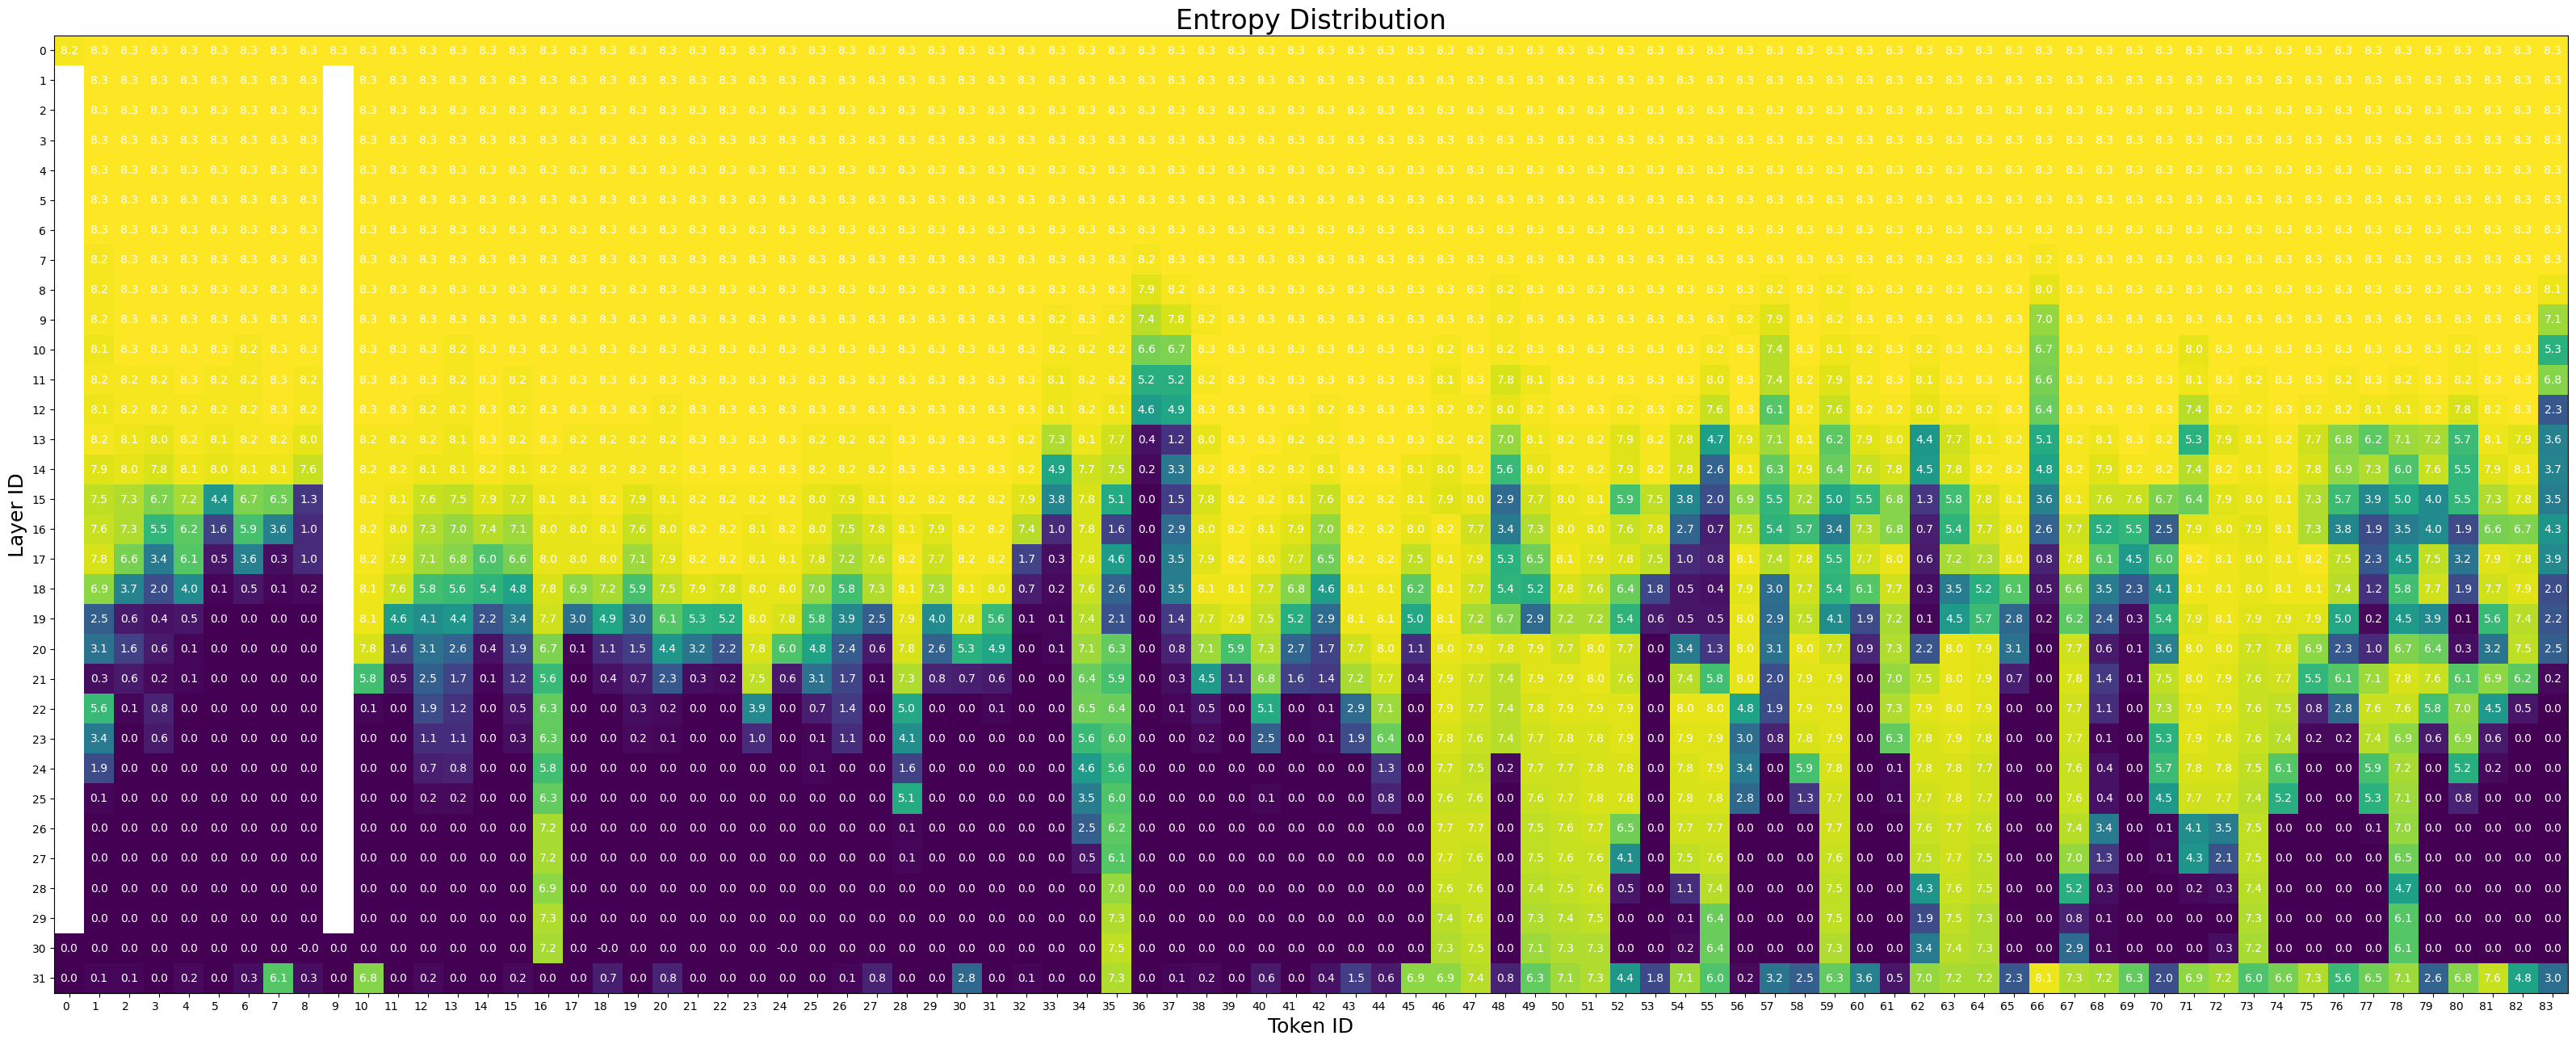

In [8]:
all_token_entropy = np.round(all_token_entropy, 1)

plt.figure(figsize=(10,6))
fig, ax = plt.subplots(1, figsize=(num_layer, num_token))
im = ax.imshow(all_token_entropy)

layers = list(range(num_layer))
tokens = list(range(num_token))

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(tokens)), labels=tokens)
ax.set_yticks(np.arange(len(layers)), labels=layers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in layers:
    for j in tokens:
        text = ax.text(j, i, all_token_entropy[i, j],
                       ha="center", va="center", color="w")

ax.set_title('Entropy Distribution', fontsize=24)
plt.xlabel('Token ID', fontsize=18)
plt.ylabel('Layer ID', fontsize=18)

fig.tight_layout()
plt.show()